In [2]:
import os
import glob

dataDir = '/home/siddhant/Pictures/Multi-class Weather Dataset'

totalImageCount = 0

for _ in glob.glob(os.path.join(dataDir, 'dataset/**/*.jpg'), recursive=True):
    totalImageCount += 1

print('Total number of images: ', totalImageCount)

Total number of images:  1122


In [3]:
#Creation of separate folders
datasetDir = os.path.join(dataDir,'dataset')
#os.mkdir(datasetDir)

trainDir = os.path.join(datasetDir, 'training')
testDir = os.path.join(datasetDir, 'testing')

#os.mkdir(trainDir)
#os.mkdir(testDir)

cloudyTrainDir = os.path.join(trainDir, 'cloudy')
rainTrainDir = os.path.join(trainDir, 'rain')
shineTrainDir = os.path.join(trainDir, 'shine')
sunriseTrainDir = os.path.join(trainDir, 'sunrise')

#os.mkdir(cloudyTrainDir)
#os.mkdir(rainTrainDir)
#os.mkdir(shineTrainDir)
#os.mkdir(sunriseTrainDir)

cloudyTestDir = os.path.join(testDir, 'cloudy')
rainTestDir = os.path.join(testDir, 'rain')
shineTestDir = os.path.join(testDir, 'shine')
sunriseTestDir = os.path.join(testDir, 'sunrise')

#os.mkdir(cloudyTestDir)
#os.mkdir(rainTestDir)
#os.mkdir(shineTestDir)
#os.mkdir(sunriseTestDir)

In [24]:
import shutil
import random

#Split data from from data into the folders created
def splitData(sourceDir, destTrainingDir, destTestingDir, splitSize):
    imageList = []
    for fileName in os.listdir(sourceDir):
        filePath = os.path.join(sourceDir, fileName)
        if os.path.getsize(filePath) > 0:
            imageList.append(fileName)
        else:
            print('Discarding image: {} since size 0:'.format(filePath))
    
    trainingSize = int(len(imageList)*splitSize)
    testingSize = len(imageList) - trainingSize
    shuffledSet = random.sample(imageList, len(imageList))
    trainingSet = shuffledSet[:trainingSize]
    testingSet = shuffledSet[trainingSize:]
    
    for imageName in trainingSet:
        shutil.copyfile(os.path.join(sourceDir, imageName), os.path.join(destTrainingDir, imageName))
        
    for imageName in testingSet:
        shutil.copyfile(os.path.join(sourceDir, imageName), os.path.join(destTestingDir, imageName))

In [25]:
splitSize = 0.8

splitData(os.path.join(dataDir, 'Cloudy'), cloudyTrainDir, cloudyTestDir, splitSize)
splitData(os.path.join(dataDir, 'Rain'), rainTrainDir, rainTestDir, splitSize)
splitData(os.path.join(dataDir, 'Shine'), shineTrainDir, shineTestDir, splitSize)
splitData(os.path.join(dataDir, 'Sunrise'), sunriseTrainDir, sunriseTestDir, splitSize)

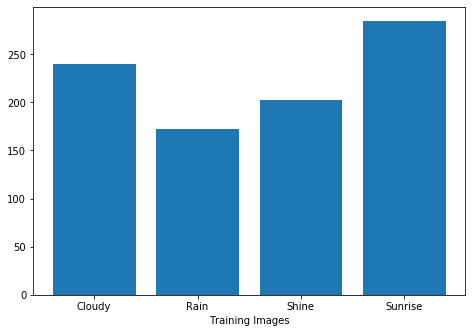

In [29]:
#Visualize number of training and testing images
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xLabel = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
trainingImagesCount = [len(os.listdir(cloudyTrainDir)),len(os.listdir(rainTrainDir)),len(os.listdir(shineTrainDir)), len(os.listdir(sunriseTrainDir))]
ax.bar(xLabel,trainingImagesCount)
plt.xlabel('Training Images')
plt.show()

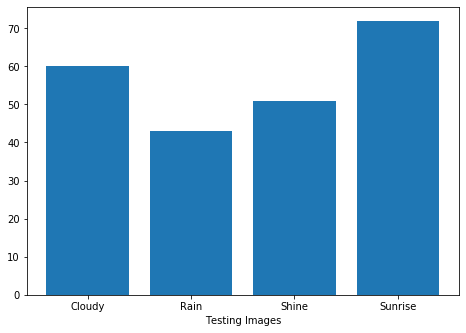

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
xLabel = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
testingImagesCount = [len(os.listdir(cloudyTestDir)),len(os.listdir(rainTestDir)),len(os.listdir(shineTestDir)), len(os.listdir(sunriseTestDir))]
ax.bar(xLabel,testingImagesCount)
plt.xlabel('Testing Images')
plt.show()

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
#Generalizing image width and height
imageWidth = 256
imageHeight = 256
batchSize=16

In [6]:
#We use ImageDataGenerator for Data Augumentation purposes.
#To generalize our model and prevent our model from overfitting, we use data augmentation techniques.

trainDataGen = ImageDataGenerator(rescale=1/255.0,
                                 rotation_range=60,
                                 zoom_range=0.4,
                                 horizontal_flip=True)

trainGenerator = trainDataGen.flow_from_directory(trainDir,
                                batch_size=batchSize,
                                class_mode='categorical',
                                target_size=(imageHeight, imageWidth))

Found 899 images belonging to 4 classes.


In [7]:
testDataGen = ImageDataGenerator(rescale=1/255.0)

testGenerator = testDataGen.flow_from_directory(testDir,
                                batch_size=batchSize,
                                class_mode='categorical',
                                target_size=(imageHeight, imageWidth),
                                shuffle=True)

Found 226 images belonging to 4 classes.


In [8]:
#monitor- Performance measured using val_loss
#mode- default-auto (minimize loss and maximize accuracy)
#verbose is set to true to know for which epoch the training is stopped
#patience- (interesting parameter) Sometimes it may happen that there is no signof improvement
#i.e., plateau or it may worsen before getting much better
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

#autosave best model
bestModelFile = os.path.join(dataDir, 'CNN_Weather_weights.h5')

bestModel = ModelCheckpoint(bestModelFile, monitor='val_acc', verbose=1, save_best_only=True)

In [10]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(imageHeight, imageWidth, 3)), MaxPooling2D(2,2),
    Conv2D(32, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    #Feature (Edges, Color, Shape) learning till this part
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
    #Softmax for multiclass classification to get belongingness to every class
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 29, 29, 64)       

In [12]:
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
history = model.fit_generator(trainGenerator,
                             epochs=30,
                             verbose=1,
                             validation_data=testGenerator,
                             callbacks = [bestModel])

Epoch 1/30
57/57 [==============================] - 75s 1s/step - loss: 1.1767 - accuracy: 0.3971 - val_loss: 0.8812 - val_accuracy: 0.5531
Epoch 2/30
57/57 [==============================] - 61s 1s/step - loss: 1.0850 - accuracy: 0.5083 - val_loss: 0.8456 - val_accuracy: 0.5575
Epoch 3/30
57/57 [==============================] - 61s 1s/step - loss: 0.8858 - accuracy: 0.6529 - val_loss: 0.6863 - val_accuracy: 0.6460
Epoch 4/30
57/57 [==============================] - 67s 1s/step - loss: 0.7129 - accuracy: 0.6819 - val_loss: 0.7328 - val_accuracy: 0.6991
Epoch 5/30
57/57 [==============================] - 67s 1s/step - loss: 0.7763 - accuracy: 0.6774 - val_loss: 0.5152 - val_accuracy: 0.7611
Epoch 6/30
57/57 [==============================] - 72s 1s/step - loss: 0.6890 - accuracy: 0.6830 - val_loss: 0.5466 - val_accuracy: 0.7389
Epoch 7/30
57/57 [==============================] - 69s 1s/step - loss: 0.5849 - accuracy: 0.7119 - val_loss: 0.4884 - val_accuracy: 0.7345
Epoch 8/30
57/57 [==

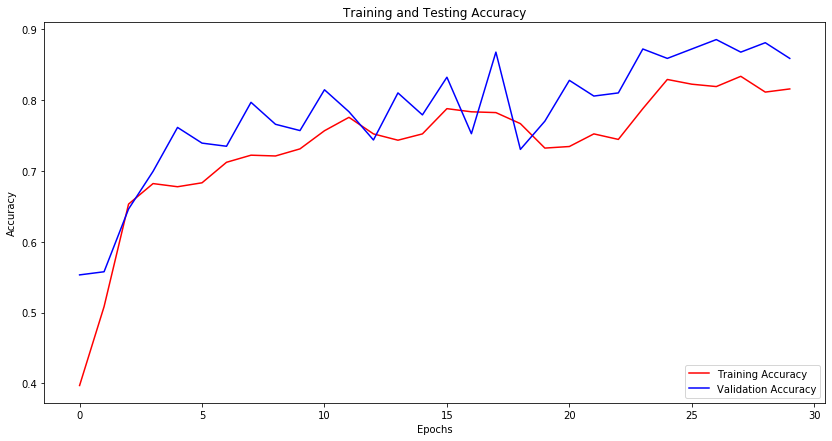

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
testAcc = history.history['val_accuracy']
loss = history.history['loss']
testLoss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, testAcc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend(loc='lower right')
plt.show()
#If red line stays high and blue line stays low, its a sign of overfitting

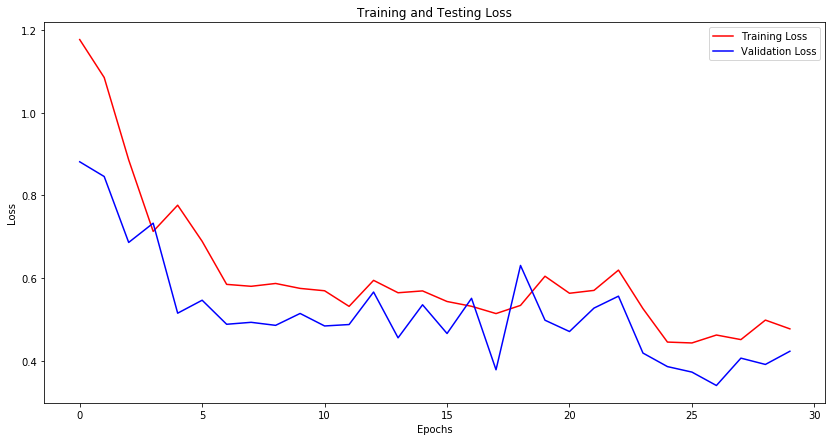

In [17]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, testLoss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend(loc='upper right')


In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocessImage(path):
    img = load_img(path, target_size=(imageHeight, imageWidth))
    arr = img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr /= 255
    return arr

In [25]:
testProcessedImage = preprocessImage(os.path.join(dataDir, 'test.jpg'))
answer = model.predict(testProcessedImage, batch_size=1, verbose=1)
answer = np.argmax(answer, axis=1)
if answer == 0:
    print('Cloudy')
elif answer == 1:
    print('Rain')
elif answer == '2':
    print('Shine')
else:
    print('Sunrise')

1/1 [==============================] - 0s 790us/step
Sunrise


/home/siddhant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
